## Unsupervised Learning
#### by **Ivan Alducin**
<p><img src="https://cdn.gritglobal.io/uploads/too-broad-customer-segmentation.jpg" width="1000"/></p>

## Segmentacion de Clientes
<p>En esté capitulo nos vamos a enfocar en entender y trabajar un caso de uso para segmentación de clientes, pero antes de eso aquí una pequeña lista de más aplicaciones que se pueden trabajar con los datos recopliados de mis clientes

- Estadística Descriptiva
- Segmentación de Clientes
- Predicción de Abandono
- Valor del Cliente a traves del tiempo (CTLV)

La segmentación la vamos a hacer con base en una metodolgía llamada <b>RFM</b>

</p>

In [2]:
# Importa Pandas, Numpy, Seaborn y Matplotlib
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# Importa el archivo "Online Retail.csv"
import os

os.chdir('./')
data = pd.read_csv('Online Retail.csv', encoding = 'latin-1')
data

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2019 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2019 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09/12/2020 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09/12/2020 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09/12/2020 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09/12/2020 12:50,4.15,12680.0,France


In [3]:
# Análisis Exploratorio
print("Dimensiones del Dataset: ", data.shape)
print("------------------------------------")
print("Columnas: ", data.columns.tolist())
print("------------------------------------")

data.info()
print("------------------------------------")
print("Valores nulos:\n",data.isnull().sum())
print("------------------------------------")
print("Valores duplicados: ", data.duplicated().sum())

Dimensiones del Dataset:  (541909, 8)
------------------------------------
Columnas:  ['INVOICE_NO', 'STOCK_CODE', 'DESCRIPTION', 'QUANTITY', 'INVOICE_DATE', 'UNIT_PRICE', 'CUSTOMER_ID', 'REGION']
------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
------------------------------------
Valores nulos:
 INVOICE_NO           0
STOCK_CODE           0
DESCRIPTION       1454
QUANTITY             0
INVOICE_

In [4]:
retail_data = data.drop_duplicates()

retail_data = retail_data[retail_data['DESCRIPTION'].notnull()]
retail_data = retail_data[retail_data['CUSTOMER_ID'].notnull()]
retail_data['INVOICE_DATE'] = pd.to_datetime(retail_data['INVOICE_DATE'], dayfirst = True)

retail_data = retail_data[(retail_data['QUANTITY'] > 0) & (retail_data['UNIT_PRICE'] > 0)]

retail_data.info()

print("------------------------------------")
print("Valores nulos:\n",retail_data.isnull().sum())
print("------------------------------------")
print("Valores duplicados: ", retail_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   INVOICE_NO    392692 non-null  object        
 1   STOCK_CODE    392692 non-null  object        
 2   DESCRIPTION   392692 non-null  object        
 3   QUANTITY      392692 non-null  int64         
 4   INVOICE_DATE  392692 non-null  datetime64[ns]
 5   UNIT_PRICE    392692 non-null  float64       
 6   CUSTOMER_ID   392692 non-null  float64       
 7   REGION        392692 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB
------------------------------------
Valores nulos:
 INVOICE_NO      0
STOCK_CODE      0
DESCRIPTION     0
QUANTITY        0
INVOICE_DATE    0
UNIT_PRICE      0
CUSTOMER_ID     0
REGION          0
dtype: int64
------------------------------------
Valores duplicados:  0


## Recency
<p>Indicador que nos dice que tan reciente es la compra de un cliente</p>

In [6]:
# Obtener los clientes unicos
customer = pd.DataFrame(retail_data['CUSTOMER_ID'].unique(), columns=['CUSTOMER_ID'])

In [5]:
# Obtener la última fecha de compra por cliente
max_purchase = (
                retail_data.groupby('CUSTOMER_ID', as_index = False)
                .agg({'INVOICE_DATE': 'max'})
                .rename(columns = {'INVOICE_DATE' : 'ULTIMA_COMPRA'})
               )

In [7]:
# Vamos a calcular nuestra metrica de Recency, esto lo haremos restando los días de la última fecha de compra a cada observacón
max_purchase['RECENCY'] = (retail_data['INVOICE_DATE'].max() - max_purchase['ULTIMA_COMPRA']).dt.days

In [8]:
# Unir el DataFrame de clientes únicos con el que acabamos de crear de la última fecha de compra
customer = pd.merge(customer, max_purchase, on = 'CUSTOMER_ID')

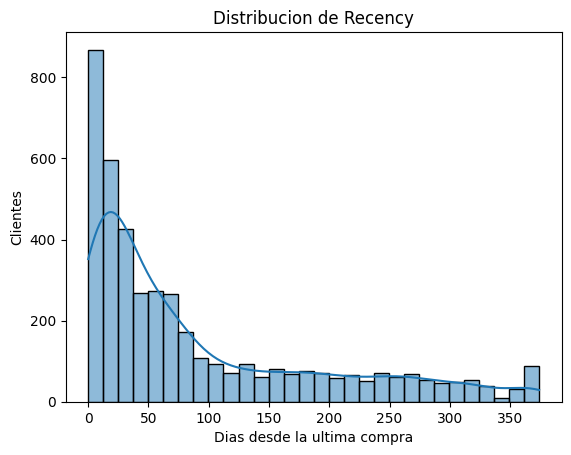

In [9]:
# Grafica un histograma de Recency
sb.histplot(data=customer, x='RECENCY', bins=30, kde=True)
plt.title('Distribucion de Recency')
plt.xlabel('Dias desde la ultima compra')
plt.ylabel('Clientes')
plt.show()

In [10]:
# Imprime la Estadística de Resumen para Recency
customer['RECENCY'].describe()

count    4338.000000
mean       91.610650
std       100.191727
min         0.000000
25%        17.000000
50%        50.000000
75%       141.000000
max       374.000000
Name: RECENCY, dtype: float64

## Frequency
<p>Frecuencia con la que un cliente compra uno o más productos</p>

In [11]:
# Obtener el número de compras por cliente
frequency = pd.DataFrame(
            retail_data.groupby('CUSTOMER_ID')['INVOICE_NO']
            .nunique()
            .reset_index()
            .rename(columns={'INVOICE_NO':'FREQUENCY'})
)

In [12]:
# Unir el DataFrame que acabamos de crear con el de los clientes unicos
customer = pd.merge(customer, frequency, on='CUSTOMER_ID')

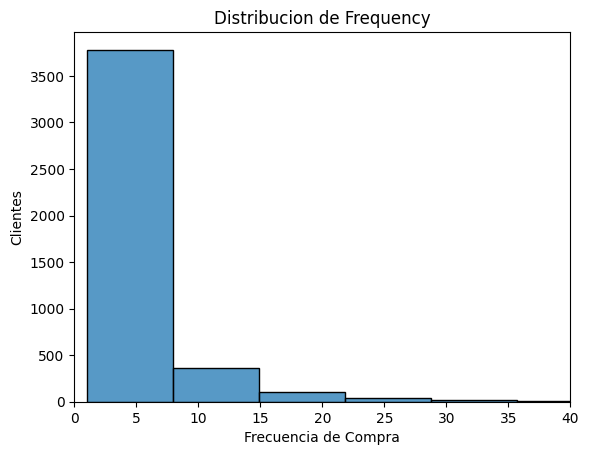

In [13]:
# Grafica un histograma de Frequency
sb.histplot(data=customer, x='FREQUENCY', bins=30, kde=False)
plt.title('Distribucion de Frequency')
plt.xlabel('Frecuencia de Compra')
plt.ylabel('Clientes')
plt.xlim(0, 40)
plt.show()

In [14]:
# Imprime la Estadística de Resumen para Frequency
customer['FREQUENCY'].describe()

count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: FREQUENCY, dtype: float64

## Monetary
<p>Valor del monto total que ha gastado un cliente en la compra de mis productos</p>

In [15]:
# Calcular el monto total por cada compra
retail_data['MONETARY'] = retail_data['QUANTITY'] * retail_data['UNIT_PRICE']

# Obtener el valor monetario de compra por cliente
monetary = pd.DataFrame(
            retail_data.groupby('CUSTOMER_ID')['MONETARY']
            .sum()
            )

In [16]:
# Unir el DataFrame que acabamos de crear con el de los clientes unicos
customer = pd.merge(customer, monetary, on='CUSTOMER_ID')

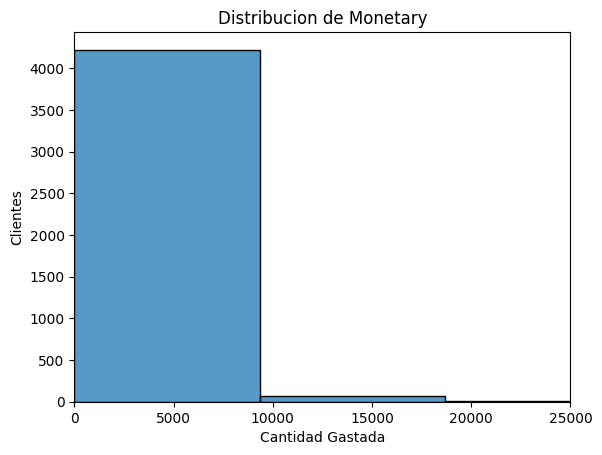

In [17]:
# Grafica un histograma de Monetary
sb.histplot(data=customer, x='MONETARY', bins=30, kde=False)
plt.title('Distribucion de Monetary')
plt.xlabel('Cantidad Gastada')
plt.ylabel('Clientes')
plt.xlim(0, 25000)
plt.show()

In [18]:
# Imprime la Estadística de Resumen para Monetary
customer['FREQUENCY'].describe()

count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: FREQUENCY, dtype: float64

## Algoritmo k-Means
<p>Ya creamos nuestros indicadores principales de la metodología RFM. es hora de hacer <i>Machine Learning</i>. Para ello utilizaremos un algoritmo no supervisado llamado <b>k-Means</b></p>
<p><img src="https://miro.medium.com/max/818/1*fG8u8nV7qR91wDyFDEEV-g.png" width="250"/></p>

In [19]:
# Funcion para ordenar los clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

## Elbow Method
<p>¿Cual es mi número óptimo de clusters? Vamos a contruir una <i>gráfica de codo</i> para averiguarlo</p>

In [20]:
# Importa la librería de kMeans
from sklearn.cluster import KMeans

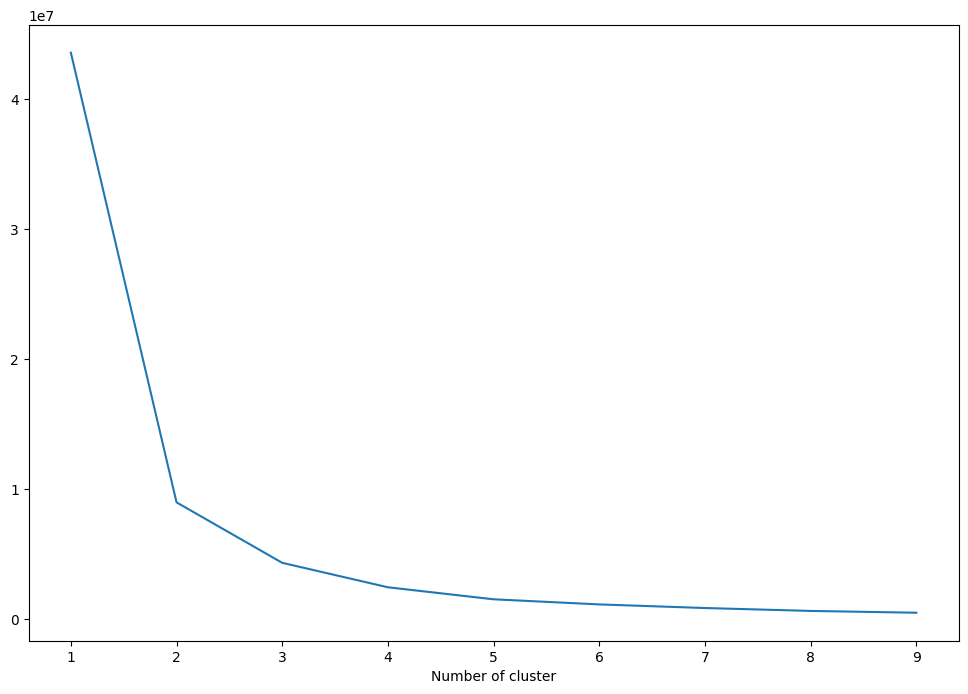

In [22]:
# Configuración inicial - Vamos a tomar como referencia el indicador de Recency
sse={}
recency = customer[['RECENCY']].copy()

for k in range(1, 10):
    # Instancia el algoritmo de k-means iterando sobre k
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=2)
    
    # Entrena el algoritmo
    kmeans.fit(recency)

    # Adjunta las etiquetas
    recency["clusters"] = kmeans.labels_
    
    # Adunta la inercia o variación al arreglo sse
    sse[k] = kmeans.inertia_
    
# Grafico de codo (Elbow)
plt.figure(figsize=(12,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [23]:
# Instanciar el algoritmo con 4 clusters para Recency 
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=2)

# Entrenar el algoritmo
kmeans.fit(recency)

# Obtener las predicciones
customer['RECENCY_CLUSTER'] = kmeans.predict(recency)

# Ordenar los clusters
customer = order_cluster('RECENCY_CLUSTER', 'RECENCY', customer, False)

# Estadística Descriptiva del cluster creado
customer.groupby('RECENCY_CLUSTER')['RECENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
RECENCY_CLUSTER,,,,,,,,
0,497.0,308.631791,39.376737,251.0,274.0,305.0,337.0,374.0
1,598.0,192.503344,31.574683,139.0,165.0,190.0,217.0,250.0
2,995.0,84.606030,23.951358,53.0,64.0,78.0,103.0,138.0
3,2248.0,19.891904,14.847852,0.0,7.0,17.0,30.0,52.0


In [26]:
# Instanciar el algoritmo con 4 clusters para Frequency 
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=2)

# Entrenar el algoritmo
kmeans.fit(customer[['FREQUENCY']])

# Obtener las predicciones
customer['FREQUENCY_CLUSTER'] = kmeans.predict(customer[['FREQUENCY']])

# Ordenar los clusters
customer = order_cluster('FREQUENCY_CLUSTER', 'FREQUENCY', customer, True)

# Estadística Descriptiva de los clusters
customer.groupby('FREQUENCY_CLUSTER')['FREQUENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
FREQUENCY_CLUSTER,,,,,,,,
0,3947.0,2.756017,2.054876,1.0,1.0,2.0,4.0,9.0
1,368.0,16.057065,6.569229,10.0,11.0,14.0,19.0,39.0
2,21.0,63.571429,22.209393,41.0,47.0,55.0,73.0,124.0
3,2.0,205.000000,5.656854,201.0,203.0,205.0,207.0,209.0


In [27]:
# Instanciar el algoritmo con 4 clusters para Monetary 
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=2)

# Entrenar el algoritmo
kmeans.fit(customer[['MONETARY']])

# Obtener las predicciones
customer['MONETARY_CLUSTER'] = kmeans.predict(customer[['MONETARY']])

# Ordenar los clusters ¿Como tienes que ordenar el cluster?
customer = order_cluster('MONETARY_CLUSTER', 'MONETARY', customer, True)

# Estadística Descriptiva de los clusters
customer.groupby('MONETARY_CLUSTER')['MONETARY'].describe()

,count,mean,std,min,25%,50%,75%,max
MONETARY_CLUSTER,,,,,,,,
0,4300.0,1433.017266,2223.372955,3.75,304.965,658.76,1614.46,21429.39
1,30.0,44853.662667,16102.568434,25977.16,31851.965,40218.17,57946.04,80850.84
2,5.0,129074.132000,29023.376747,91062.38,117210.080,124914.53,143711.17,168472.50
3,3.0,244751.370000,44807.404375,194390.79,227024.045,259657.30,269931.66,280206.02


## Score de Segmentación
<p>El algoritmo de k-means nos da una segmentación generalizada, pero podemos personalizarla aún más creando una métrica que asigne una calificación al valor del cluster. Esto es lo que vamos a hacer!!</p>

In [28]:
# Vamos a crear nuestro score sumando el valor de cada uno de los clusters
customer['SCORE'] = customer['RECENCY_CLUSTER'] + customer['FREQUENCY_CLUSTER'] + customer['MONETARY_CLUSTER']

# Obtener el promedio para cada una de las métricas de las calificaciones creadas (Score)
customer['SCORE'].mean()

2.2584140156754264

In [30]:
# Crea una funcion que asigne lo siguiente: 
# Si score <= 1 entonces 'Low-Value', si score >1 y <=4 entonces 'Average', si score >4 y <=6 entonces 'Potential', por último si score >6 entonces 'High-Value'
def segment(score):
    if score <= 1:
        return 'Low-Value'
    elif 1 < score <= 4:
        return 'Average'
    elif 4 < score <= 6:
        return 'Potential'
    elif score > 6:
        return 'High-Value'

# Crear una columna aplicando esta función al campo 'SCORE'
customer['SEGMENT'] = customer['SCORE'].apply(segment)

In [31]:
# Vamos a dar un vistazo a la tabla final
customer.head()

,CUSTOMER_ID,ULTIMA_COMPRA,RECENCY,FREQUENCY,MONETARY,RECENCY_CLUSTER,FREQUENCY_CLUSTER,MONETARY_CLUSTER,SCORE,SEGMENT
0,17850.0,2019-12-02 15:27:00,372,34,5391.21,0,1,0,1,Low-Value
1,13047.0,2020-11-08 12:06:00,31,10,3237.54,3,1,0,4,Average
2,12583.0,2020-12-07 08:07:00,2,15,7281.38,3,1,0,4,Average
3,15291.0,2020-11-14 11:02:00,25,15,4668.30,3,1,0,4,Average
4,14688.0,2020-12-02 12:26:00,7,21,5579.10,3,1,0,4,Average


In [32]:
# Imprime la proporción o el total de clientes por segmento
customer['SEGMENT'].value_counts()

Average       3208
Low-Value     1090
Potential       34
High-Value       6
Name: SEGMENT, dtype: int64

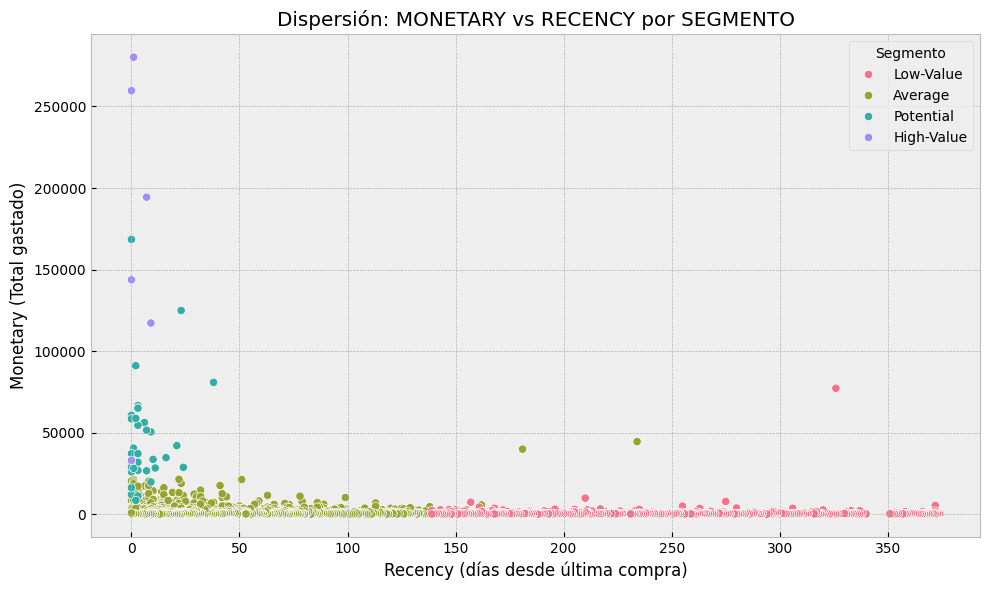

In [43]:
# Define un estilo 'bmh'
plt.style.use('bmh')

# Filtra los valores para RECENCY < 4000
recency_filtered = customer[customer['RECENCY'] < 4000]

# Crea un grafico de dispersion de 'MONETARY' VS 'RECENCY' por Segmento
plt.figure(figsize=(10, 6))
sb.scatterplot(data=customer, x='RECENCY', y='MONETARY', hue='SEGMENT', palette='husl')
plt.title('Dispersión: MONETARY vs RECENCY por SEGMENTO')
plt.xlabel('Recency (días desde última compra)')
plt.ylabel('Monetary (Total gastado)')
plt.legend(title='Segmento')
plt.tight_layout()
plt.show()

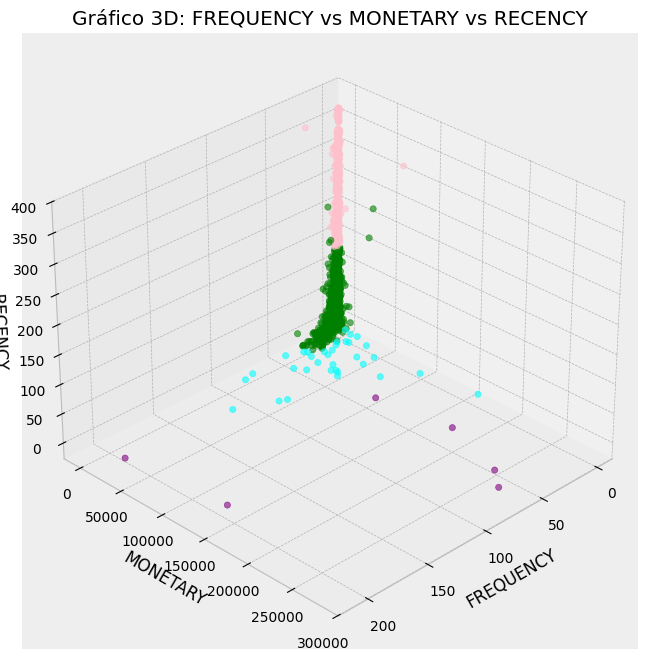

In [52]:
# Crea un grafico de dispersion de 'MONETARY' vs 'FREQUENCY' vs  por Segmento
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = {'Low-Value': 'pink', 'Average': 'green', 'Potential': 'cyan', 'High-Value': 'purple'}
segment_colors = customer['SEGMENT'].map(colors)

ax.scatter(
    customer['FREQUENCY'],
    customer['MONETARY'],
    customer['RECENCY'],
    c=segment_colors,
    alpha=0.6
)

ax.view_init(elev=30, azim=45)

ax.set_xlabel('FREQUENCY')
ax.set_ylabel('MONETARY')
ax.set_zlabel('RECENCY')
plt.title('Gráfico 3D: FREQUENCY vs MONETARY vs RECENCY')
plt.show()

### Conclusiones

El algoritmo Kmeans es una herramienta muy util, y hasta "poderosa" al momento de identificar patrones y caracteristicas de valor. En este caso, se pudo conocer de entre todos los datos, cuales clientes son los de mayor valor, y cuales son los de menor participación a la hora de adquirir productos.
    Son claras las oportunidades que nos brinda este proceso. Por ejemplo, nos puede permitir ofrecer programas de recompensa, analisis de los productos que son adquiridos por los clientes de mayor valor, y hasta podriamos estudiar las variables que nos permitan convertir a los clientes potenciales a alto valor, y de promedio a potencial, etc...
    Con esta practica queda claro el potencial de este proceso, y como el desglose de cada una de las variables como lo fueron "Recency, Monetary y Frequency" van abriendo el panorama poco a poco.

Alumno: Ian Badillo